In [1]:
import pandas as pd
from pathlib import Path

a2_df_census_ol_pejeta_eastern = pd.read_pickle("../data/pkl/a2_df_census_ol_pejeta_eastern.pkl")
a2_df_census_ol_pejeta_eastern_rank = pd.read_pickle("../data/pkl/a2_df_census_ol_pejeta_eastern_rank.pkl")
a2_df_census_ol_pejeta_eastern_rank.head()

Year,2005,2006,2007,2008,2009,2010,2012,2013,2014,2015,2016,2017,2019,2020,2021,2022,2023
Species,,,,,,,,,,,,,,,,,
Acinonyx jubatus,16,18,19,18,20,21,18,20,22,18,18,17,17,18,17,18,17
Aepyceros melampus,3,2,3,3,1,1,1,1,3,1,1,2,2,2,2,2,3
Alcelaphus buselaphus,12,12,11,11,7,9,11,8,12,9,11,11,7,10,12,14,14
Canis mesomelas,16,18,19,18,17,18,20,18,18,17,18,17,17,18,17,18,17
Ceratotherium simum simum,16,18,16,16,15,14,15,14,15,12,13,12,10,13,10,12,11


In [2]:
import pandas as pd
import numpy as np

summary = a2_df_census_ol_pejeta_eastern.copy()

to_rank = (
    summary
    .drop(index="Column_Total", errors="ignore")
    .drop(columns=["Row_Total"], errors="ignore")
)

ranks_wide = to_rank.rank(axis=0, method='min', ascending=False)

# 1) Reciprocal-rank weights (higher rank -> smaller weight)
recip = (1 / ranks_wide).astype(float).fillna(0)

# 2) Normalize within each year so column weights sum to 1 (makes years comparable)
recip_norm = recip.div(recip.sum(axis=0).replace(0, np.nan), axis=1).fillna(0)

# 3) A cross-year dominance score per species (equal weight to each year)
species_recip_score = recip_norm.mean(axis=1).sort_values(ascending=False)

# Optional: “Borda-like” linear rank weights, also normalised per year
max_rank_per_year = ranks_wide.max(skipna=True)
borda = (max_rank_per_year - ranks_wide + 1)  # top rank gets largest weight
borda_norm = borda.div(borda.sum(axis=0).replace(0, np.nan), axis=1).fillna(0)
species_borda_score = borda_norm.mean(axis=1).sort_values(ascending=False)

borda.head()

Year,2005,2006,2007,2008,2009,2010,2012,2013,2014,2015,2016,2017,2019,2020,2021,2022,2023
Species,,,,,,,,,,,,,,,,,
Acinonyx jubatus,1.0,1.0,1.0,1.0,3.0,1.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Aepyceros melampus,14.0,17.0,17.0,16.0,22.0,21.0,20.0,20.0,20.0,18.0,18.0,16.0,16.0,17.0,16.0,17.0,15.0
Alcelaphus buselaphus,5.0,7.0,9.0,8.0,16.0,13.0,10.0,13.0,11.0,10.0,8.0,7.0,11.0,9.0,6.0,5.0,4.0
Canis mesomelas,1.0,1.0,1.0,1.0,6.0,4.0,1.0,3.0,5.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Ceratotherium simum simum,1.0,1.0,4.0,3.0,8.0,8.0,6.0,7.0,8.0,7.0,6.0,6.0,8.0,6.0,8.0,7.0,7.0


In [3]:
species_borda_score.head(50)

Species
Syncerus caffer              0.092892
Aepyceros melampus           0.092529
Equus burchellii             0.090731
Eudorcas thomsonii           0.078360
Nanger granti                0.076100
Phacochoerus africanus       0.067705
Kobus ellipsiprymnus         0.055970
Loxodonta africana           0.053364
Papio anubis                 0.053298
Alcelaphus buselaphus        0.045667
Diceros bicornis             0.043587
Giraffa camelopardalis       0.043206
Taurotragus oryx             0.042594
Ceratotherium simum simum    0.030983
Equus grevyi                 0.027464
Oryx beisa                   0.021836
Panthera leo                 0.014136
Tragelaphus scriptus         0.009404
Crocuta                      0.009228
Canis mesomelas              0.008986
Hippopotamus amphibius       0.008099
Redunca redunca              0.007412
Equus                        0.007120
Lycaon pictus                0.006967
Acinonyx jubatus             0.006331
Raphicerus campestris        0.006030
dtyp

In [4]:
# Proportional abundances per year
prop = to_rank.div(to_rank.sum(axis=0).replace(0, np.nan), axis=1)

# Shannon diversity H' and Pielou evenness J' per year
H = -(prop * np.log(prop.replace(0, np.nan))).sum(axis=0)
S = (to_rank > 0).sum(axis=0)                    # richness
J = H / np.log(S.replace(0, np.nan))

# Bray–Curtis dissimilarity needs pairwise comparisons; Spearman rank corr for rank stability:
spearman_by_year = to_rank.corr(method='spearman')  # columns = years
prop.head()

Year,2005,2006,2007,2008,2009,2010,2012,2013,2014,2015,2016,2017,2019,2020,2021,2022,2023
Species,,,,,,,,,,,,,,,,,
Acinonyx jubatus,0.000000,0.000000,0.000000,0.000000,0.000306,0.000000,0.000350,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Aepyceros melampus,0.165689,0.165859,0.181860,0.171155,0.323242,0.204847,0.323889,0.282951,0.211888,0.287665,0.279306,0.230720,0.232400,0.247706,0.169657,0.250624,0.168669
Alcelaphus buselaphus,0.004399,0.004847,0.008660,0.005034,0.037003,0.025369,0.010143,0.032235,0.009906,0.019503,0.017774,0.009681,0.025445,0.011796,0.008157,0.002496,0.005506
Canis mesomelas,0.000000,0.000000,0.000000,0.000000,0.000612,0.001136,0.000000,0.000716,0.001926,0.001463,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Ceratotherium simum simum,0.000000,0.000000,0.001367,0.000503,0.001529,0.004165,0.002448,0.003940,0.004953,0.010239,0.006348,0.008712,0.011874,0.009174,0.009788,0.007988,0.014515


In [5]:
abund = a2_df_census_ol_pejeta_eastern

In [6]:
def diversity_metrics(abund: pd.DataFrame) -> pd.DataFrame:
    # proportions per year
    col_sums = abund.sum(axis=0)
    prop = abund.div(col_sums.replace(0, np.nan), axis=1)

    # richness (Hill N0)
    S = (abund > 0).sum(axis=0)

    # Shannon (H'), Hill N1 = exp(H')
    H = -(prop * np.log(prop.replace(0, np.nan))).sum(axis=0).fillna(0)
    N1 = np.exp(H)

    # Simpson D = sum p^2, Hill N2 = 1/D
    D = (prop ** 2).sum(axis=0).fillna(0)
    N2 = (1 / D.replace(0, np.nan)).fillna(0)

    # Evenness: Pielou J' and Hill evenness (N1/S)
    J = (H / np.log(S.replace(0, np.nan))).fillna(0)
    E_hill = (N1 / S.replace(0, np.nan)).fillna(0)

    out = pd.DataFrame({
        "Richness_S": S,
        "Shannon_H'": H,
        "Hill_N1": N1,
        "Simpson_D": D,
        "Hill_N2": N2,
        "Pielou_J'": J,
        "Hill_evenness_N1_over_S": E_hill,
        "Total_Abundance": col_sums
    })
    out.index.name = "Year"
    return out

metrics = diversity_metrics(abund)
metrics.round(3).head(50)

,Richness_S,Shannon_H',Hill_N1,Simpson_D,Hill_N2,Pielou_J',Hill_evenness_N1_over_S,Total_Abundance
Year,,,,,,,,
2005,16,1.693,5.433,0.295,3.393,0.610,0.340,2728
2006,18,1.679,5.359,0.297,3.366,0.581,0.298,3714
2007,19,1.752,5.765,0.288,3.473,0.595,0.303,4388
2008,18,1.677,5.349,0.296,3.374,0.580,0.297,7946
2009,22,1.719,5.581,0.294,3.397,0.556,0.254,6540
2010,21,1.810,6.111,0.284,3.527,0.595,0.291,5282
2012,20,1.729,5.633,0.293,3.412,0.577,0.282,5718
2013,20,1.745,5.724,0.292,3.425,0.582,0.286,5584
2014,22,1.732,5.653,0.293,3.413,0.560,0.257,7268


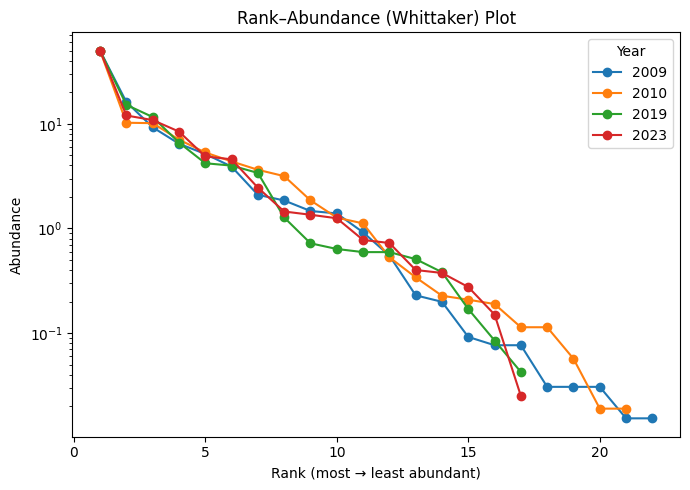

In [7]:
import matplotlib.pyplot as plt

def whittaker_plot(abund: pd.DataFrame, years=None, log_y=True):
    """
    Draws rank–abundance curves. One curve per year.
    """
    if years is None:
        years = list(abund.columns)

    plt.figure(figsize=(7, 5))
    for yr in years:
        s = abund[yr]
        s = s[s > 0].sort_values(ascending=False)  # positive abundances only
        if s.empty:
            continue
        ranks = np.arange(1, len(s) + 1)
        plt.plot(ranks, s.values, marker="o", label=str(yr))

    plt.xlabel("Rank (most → least abundant)")
    plt.ylabel("Abundance")
    if log_y:
        plt.yscale("log")  # classic Whittaker uses log-abundance
    plt.title("Rank–Abundance (Whittaker) Plot")
    plt.legend(title="Year")
    plt.tight_layout()
    plt.show()

# Example: plot a few years (or omit 'years=' to plot all)
#whittaker_plot(abund, years=[2005, 2009, 2017, 2023], log_y=True)
#whittaker_plot(prop*100, years=[2009, 2023], log_y=False)
#whittaker_plot(abund, years=[2008, 2019], log_y=True)
#whittaker_plot(abund, years=[2009, 2010, 2019, 2023], log_y=True)
prop = abund.div(abund.sum(axis=0).replace(0, np.nan), axis=1).fillna(0)
whittaker_plot(prop*100, years=[2009, 2010, 2019, 2023], log_y=True)